In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.tree import DecisionTreeRegressor 
import sklearn.model_selection as model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import neighbors
from math import sqrt

#### Question: How to predict the price of a property?
#### Question: How to predict the condition of a property?
#### Question: Whether the price and sales volume have some systematic pattern over the time period?
#### Question: Which algorithm is best? Predict the price by K nearest neighbor? Random Forest? SVR? Simple Linear Reg?

In [3]:
df=pd.read_csv('project_data.csv')

In [4]:
#list(df)
#PRICE #SALEDATE
df['SALEDATE']=pd.to_datetime(df['SALEDATE'])
df['year'] = df['SALEDATE'].dt.year
df = df[np.isfinite(df['year'])]

In [5]:
df['price_zero'] = np.where(df.PRICE > 0 , 1,0)
df = df[df.price_zero != 0]

In [6]:
#df = df.drop(['price_zero','X','Y','CMPLX_NUM','FULLADDRESS','LONGITUDE','CITY','STATE','NATIONALGRID','CENSUS_BLOCK','SALEDATE','QUADRANT'],axis=1)

df.GBA = df.GBA.fillna(df.GBA.mean())

df.AYB = df.AYB.fillna(df.AYB.median())

df.STORIES = df.STORIES.fillna(df.STORIES.median())

df.KITCHENS = df.KITCHENS.fillna(df.KITCHENS.median())

df.NUM_UNITS = df.NUM_UNITS.fillna(df.NUM_UNITS.median())

df.YR_RMDL = df.YR_RMDL.fillna(df.YR_RMDL.median())

#df.LIVING_GBA = df.LIVING_GBA.fillna(df.LIVING_GBA.mean())

df.STYLE = df.STYLE.fillna(df.STYLE.mode()[0])

df.STRUCT = df.STRUCT.fillna(df.STRUCT.mode()[0])

df.GRADE = df.GRADE.fillna(df.GRADE.mode()[0])

df.CNDTN = df.CNDTN.fillna(df.CNDTN.mode()[0])

df.EXTWALL = df.EXTWALL.fillna(df.EXTWALL.mode()[0])

df.ROOF = df.ROOF.fillna(df.ROOF.mode()[0])

df.INTWALL = df.INTWALL.fillna(df.INTWALL.mode()[0])

df.ASSESSMENT_SUBNBHD  = df.ASSESSMENT_SUBNBHD.fillna(df.ASSESSMENT_SUBNBHD.mode()[0])

df.isnull().sum()


AC                                            0
ASSESSMENT_NBHD                               0
ASSESSMENT_SUBNBHD                            0
AYB                                           0
BATHRM                                        0
BEDRM                                         0
BLDG_NUM                                      0
CENSUS_BLOCK                                  0
CENSUS_TRACT                                  0
CITY                                          0
CLOSEST_CAFETERIA_NAME                        0
CLOSEST_GROCERY_STORE_NAME                    0
CLOSEST_LIBRARY_NAME                          0
CLOSEST_METRO_STATION_NAME                    0
CLOSEST_PUBLIC_HOUSING_NAME                   0
CNDTN                                         0
EXTWALL                                       0
EYB                                           0
FIREPLACES                                    0
FULLADDRESS                                   0
GBA                                     

In [7]:
df['PRICE'].describe()

count    5.756400e+04
mean     5.798115e+05
std      6.064011e+05
min      1.000000e+00
25%      2.400000e+05
50%      4.400000e+05
75%      7.500000e+05
max      2.510000e+07
Name: PRICE, dtype: float64

In [8]:
df['ROOMS'].describe()

count    57564.000000
mean         7.446859
std          2.303148
min          0.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         31.000000
Name: ROOMS, dtype: float64

## run through some models using just the numeric columns

In [9]:
ndf=df.select_dtypes(include=[np.number])

In [10]:
#grab middle 50% of the data based on the price
lower_quantile, upper_quantile = df.PRICE.quantile([.25, .75])

df= df.loc[(df.PRICE > lower_quantile) & (df.PRICE < upper_quantile)]
ndf=ndf.loc[(ndf.PRICE > lower_quantile) & (ndf.PRICE < upper_quantile)]

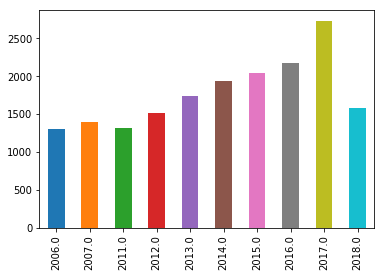

In [11]:
#years with most properties sold
df['year'].value_counts().nlargest(10).sort_index().plot.bar()

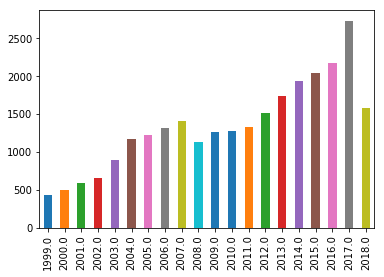

In [12]:
df['year'].value_counts().nlargest(20).sort_index().plot.bar()

## get correlation matrix w these numerical cols

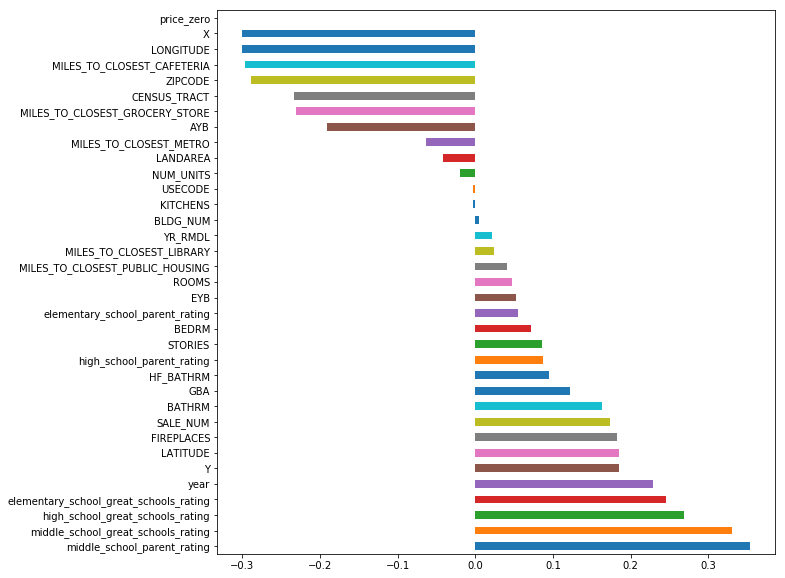

In [13]:
corr_mat=ndf.corr()

plt.figure(figsize=(10,10))
#correlation w PRICE
(corr_mat
     .PRICE
     .drop('PRICE') # don't compare with itself
     .sort_values(ascending=False)
     .plot
     .barh())

### grab top 10 cols from the corr matrix and use as feature cols

In [14]:
corr_mat.PRICE.drop('PRICE').abs().sort_values(ascending=False).head(11).index #don't select both longitiude and X

Index(['middle_school_parent_rating', 'middle_school_great_schools_rating',
       'X', 'LONGITUDE', 'MILES_TO_CLOSEST_CAFETERIA', 'ZIPCODE',
       'high_school_great_schools_rating',
       'elementary_school_great_schools_rating', 'CENSUS_TRACT',
       'MILES_TO_CLOSEST_GROCERY_STORE', 'year'],
      dtype='object')

In [17]:
#paste these into a features list
features=['middle_school_parent_rating', 'middle_school_great_schools_rating',
       'LONGITUDE', 'MILES_TO_CLOSEST_CAFETERIA', 'ZIPCODE',
       'high_school_great_schools_rating',
       'elementary_school_great_schools_rating', 'CENSUS_TRACT',
       'MILES_TO_CLOSEST_GROCERY_STORE', 'year']

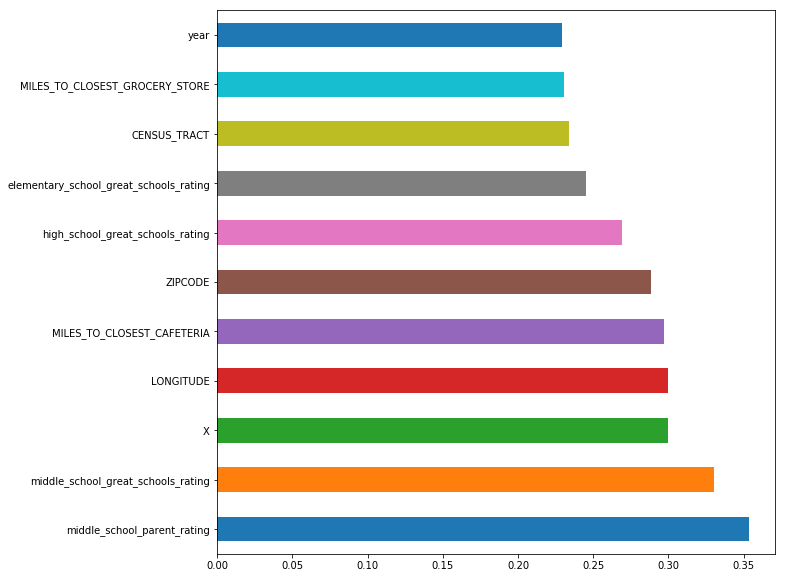

In [18]:
#corr_mat=ndf.corr()

plt.figure(figsize=(10,10))
#correlation w PRICE
(corr_mat
     .PRICE
     .drop('PRICE') # don't compare with itself
     .abs().sort_values(ascending=False).head(11)
     .plot
     .barh())

### filling NaNs with the mean for now, but we can change this in future

In [19]:
ndf.fillna(ndf.mean(), inplace=True)

## Decision Tree Regressor

In [20]:
X = ndf[features]
y = ndf['PRICE']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.75,test_size=0.25, random_state=101)
clf = DecisionTreeRegressor()

clf.fit(X_train,y_train)

importances=clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 9 (0.234622)
2. feature 2 (0.198434)
3. feature 4 (0.170115)
4. feature 3 (0.152626)
5. feature 8 (0.117434)
6. feature 7 (0.091507)
7. feature 6 (0.014234)
8. feature 1 (0.011411)
9. feature 5 (0.006969)
10. feature 0 (0.002646)


Text(0.5, 0, 'index of the feature')

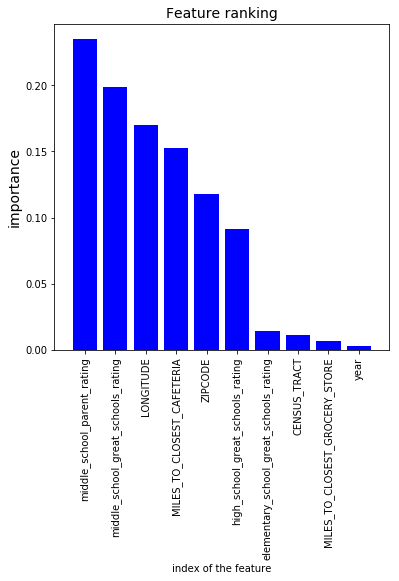

In [21]:
feature_names = X_train.columns

f, ax = plt.subplots(figsize=(6, 6))
plt.title("Feature ranking", fontsize = 14)
plt.bar(range(X_train.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("importance", fontsize = 14)
plt.xlabel("index of the feature", fontsize = 10)

In [22]:
preds = clf.predict(X_test[features])

print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))

MAE: 92710.8528466
MSE: 15768329075.1


## Linear Regression

In [38]:
from sklearn import linear_model
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

# Make predictions using the testing set
regr_pred = regr.predict(X_test)


print("MAE:", mean_absolute_error(y_test, regr_pred))
print("MSE:", mean_squared_error(y_test, regr_pred))

MAE: 87000.096129
MSE: 11535252594.5


## Support Vector Regressor

In [22]:
#Feature Scaling

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_train)

x_test=sc_X.fit_transform(X_test)


# most important SVR parameter is Kernel type. need to test out later.
regressor = SVR(kernel='rbf')
regressor.fit(X,y_train)
#5 Predicting a new result
y_pred = regressor.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

MAE: 340983.522657
MSE: 359077381965.0


## Predict based on nearest neighbors

In [23]:
rmse_val = [] #to store rmse values for different k
mae_val=[]
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    error2 = sqrt(mean_absolute_error(y_test,pred)) #calculate rmse
    mae_val.append(error2) #store rmse values
    print('MAE value for k= ' , K , 'is:', error2)
    print('MSE value for k= ' , K , 'is:', error)
    print('-----------------------------')

MAE value for k=  1 is: 543.2419303968378
MSE value for k=  1 is: 608782.2064304084
-----------------------------
MAE value for k=  2 is: 514.1183915063002
MSE value for k=  2 is: 519482.2895586292
-----------------------------
MAE value for k=  3 is: 502.18983902931865
MSE value for k=  3 is: 466595.68749971763
-----------------------------
MAE value for k=  4 is: 496.0041243193557
MSE value for k=  4 is: 441201.98393586854
-----------------------------
MAE value for k=  5 is: 491.68633554394023
MSE value for k=  5 is: 427962.1076125369
-----------------------------
MAE value for k=  6 is: 490.30468886027893
MSE value for k=  6 is: 430619.8549542513
-----------------------------
MAE value for k=  7 is: 487.32423659378617
MSE value for k=  7 is: 421495.542795598
-----------------------------
MAE value for k=  8 is: 486.00439979751405
MSE value for k=  8 is: 415849.93411838455
-----------------------------
MAE value for k=  9 is: 484.79548138180047
MSE value for k=  9 is: 411854.0183748

## categorical variables

In [23]:
#define categorical variables to encode for model
#more tweaking here probably needed
categorical = ['WARD','TYPE','STYLE','STRUCT', 'GRADE','CNDTN','EXTWALL','ROOF']

### create dummy vars and append to original dataframe

In [24]:
dummies=pd.get_dummies(df[categorical])

In [25]:
cdf = pd.concat([df,dummies],axis=1)
#cdf.head()

#### deal w nulls

In [26]:
#kind of slow -- takes a while
cdf.fillna(cdf.mean(), inplace=True)

## correlation matrix with dummy vars included

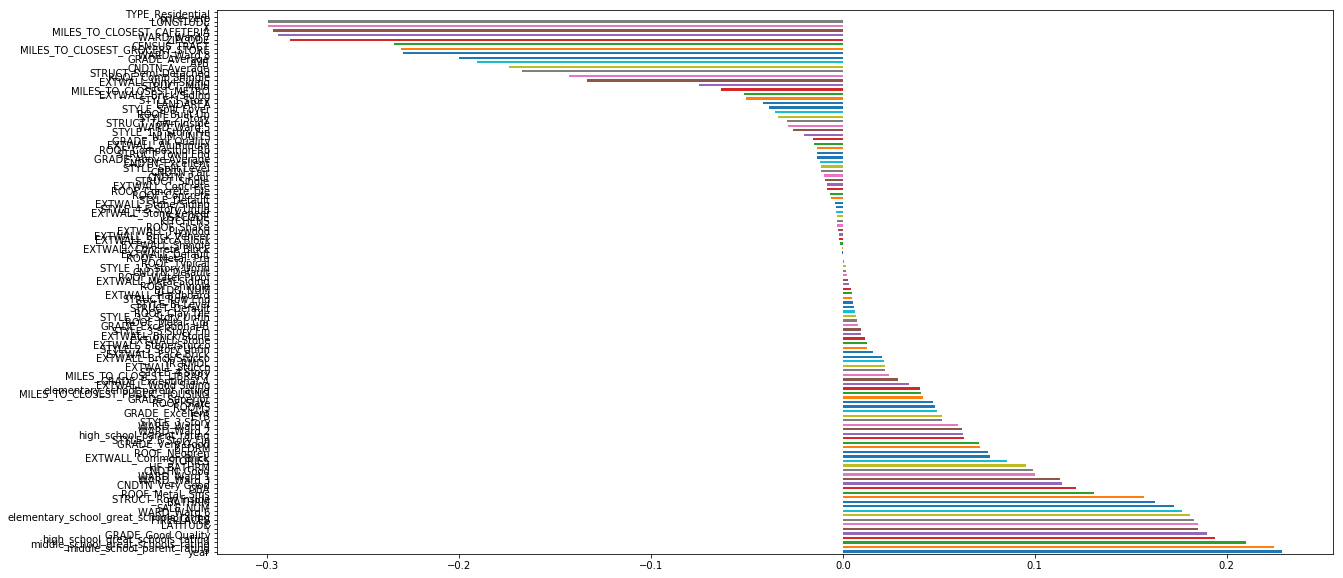

In [27]:
corr_mat=cdf.corr()

plt.figure(figsize=(20,10))
#correlation w PRICE
(corr_mat
     .PRICE
     .drop('PRICE') # don't compare with itself
     .sort_values(ascending=False)
     .plot
     .barh())

### icky!

In [28]:
corr_mat.PRICE.drop('PRICE').abs().sort_values(ascending=False).head(20).index

Index(['LONGITUDE', 'X', 'MILES_TO_CLOSEST_CAFETERIA', 'WARD_Ward 7',
       'ZIPCODE', 'CENSUS_TRACT', 'MILES_TO_CLOSEST_GROCERY_STORE',
       'WARD_Ward 8', 'year', 'middle_school_parent_rating',
       'middle_school_great_schools_rating', 'GRADE_Average',
       'high_school_great_schools_rating', 'AYB', 'GRADE_Good Quality', 'Y',
       'LATITUDE', 'FIREPLACES', 'elementary_school_great_schools_rating',
       'WARD_Ward 6'],
      dtype='object')

### barplot using correlation matrix with top 20 most correlated vars to PRICE

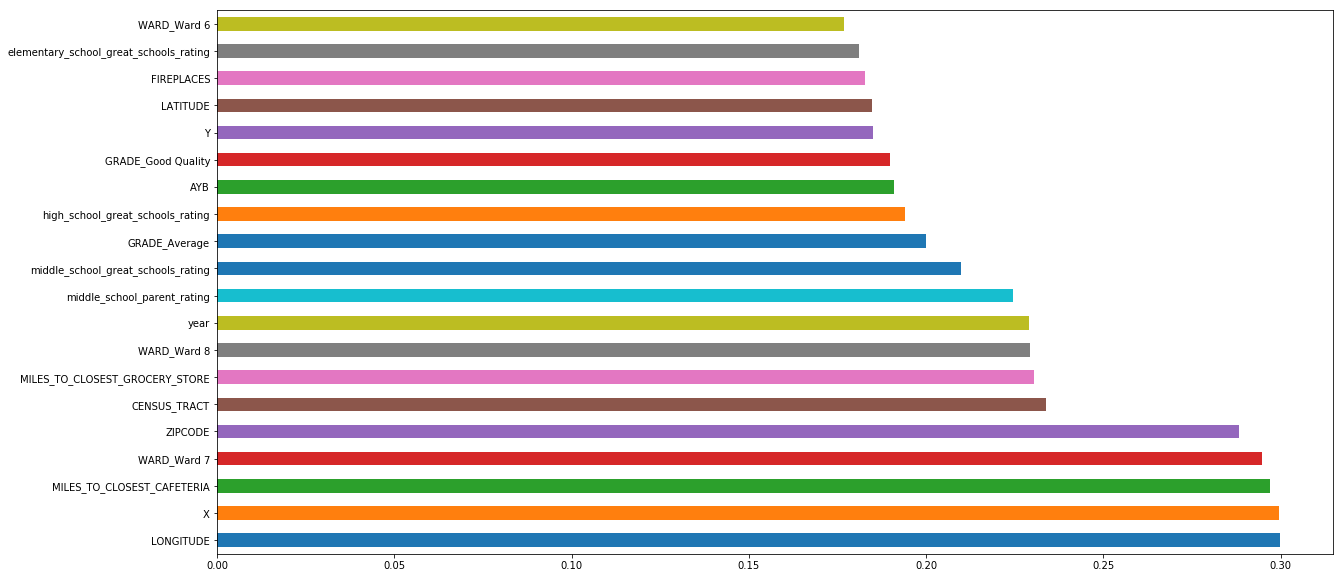

In [29]:
plt.figure(figsize=(20,10))
#correlation w PRICE
(corr_mat
     .PRICE
     .drop('PRICE') # don't compare with itself
     .sort_values(ascending=False)
     .abs().sort_values(ascending=False).head(20)
     .plot
     .barh())

In [34]:
#paste in the list of features from above, remove X and Y bc we already have lat an long
features=['LONGITUDE', 'MILES_TO_CLOSEST_CAFETERIA', 'WARD_Ward 7',
       'ZIPCODE', 'CENSUS_TRACT', 'MILES_TO_CLOSEST_GROCERY_STORE',
       'WARD_Ward 8', 'year', 'middle_school_parent_rating',
       'middle_school_great_schools_rating', 'GRADE_Average',
       'high_school_great_schools_rating', 'AYB', 'GRADE_Good Quality', 
       'LATITUDE', 'FIREPLACES', 'elementary_school_great_schools_rating',
       'WARD_Ward 6']

## decision tree regressor

In [35]:
X = cdf[features]
y = cdf['PRICE']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.75,test_size=0.25, random_state=101)
clf = DecisionTreeRegressor()

clf.fit(X_train,y_train)

importances=clf.feature_importances_
indices = np.argsort(importances)[::-1]

preds = clf.predict(X_test[features])

print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

MAE: 88783.5059449
MSE: 14727253709.1
Feature ranking:
1. feature 7 (0.205660)
2. feature 0 (0.166614)
3. feature 3 (0.146442)
4. feature 1 (0.088921)
5. feature 14 (0.085009)
6. feature 12 (0.065682)
7. feature 5 (0.064509)
8. feature 10 (0.050385)
9. feature 4 (0.049768)
10. feature 15 (0.026007)
11. feature 13 (0.022920)
12. feature 16 (0.009459)
13. feature 17 (0.006673)
14. feature 11 (0.005297)
15. feature 9 (0.003346)
16. feature 8 (0.002457)
17. feature 6 (0.000733)
18. feature 2 (0.000119)


Text(0.5, 0, 'index of the feature')

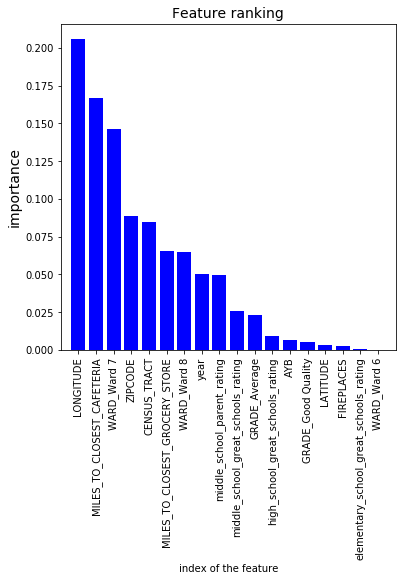

In [36]:
feature_names = X_train.columns

f, ax = plt.subplots(figsize=(6, 6))
plt.title("Feature ranking", fontsize = 14)
plt.bar(range(X_train.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("importance", fontsize = 14)
plt.xlabel("index of the feature", fontsize = 10)

## linear regression

In [39]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

# Make predictions using the testing set
regr_pred = regr.predict(X_test)


print("MAE:", mean_absolute_error(y_test, regr_pred))
print("MSE:", mean_squared_error(y_test, regr_pred))

### print coefficients of linear regression

pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)

MAE: 87000.096129
MSE: 11535252594.5


,0,0
0,LONGITUDE,-1.305401e+06
1,MILES_TO_CLOSEST_CAFETERIA,-1.013381e+04
2,WARD_Ward 7,-7.772250e+04
3,ZIPCODE,-2.492467e+02
4,CENSUS_TRACT,-3.235542e+00
5,MILES_TO_CLOSEST_GROCERY_STORE,1.187359e+04
6,WARD_Ward 8,-1.926772e+05
7,year,1.433154e+04
8,middle_school_parent_rating,-7.854554e+03
9,middle_school_great_schools_rating,1.880497e+03


## Support vector regressor

In [40]:
#Feature Scaling

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_train)

x_test=sc_X.fit_transform(X_test)


# most important SVR parameter is Kernel type. need to test out later.
regressor = SVR(kernel='rbf')
regressor.fit(X,y_train)
#5 Predicting a new result
y_pred = regressor.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

MAE: 127021.638541
MSE: 22418335597.3


## predict based on nearest neighbors

In [41]:
rmse_val = [] #to store rmse values for different k
mae_val=[]
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    error2 = sqrt(mean_absolute_error(y_test,pred)) #calculate rmse
    mae_val.append(error2) #store rmse values
    print('MAE value for k= ' , K , 'is:', error2)
    print('MSE value for k= ' , K , 'is:', error)
    print('-----------------------------')

MAE value for k=  1 is: 301.052512812458
MSE value for k=  1 is: 123063.55756945847
-----------------------------
MAE value for k=  2 is: 284.5208336306814
MSE value for k=  2 is: 108477.29026184736
-----------------------------
MAE value for k=  3 is: 280.1382381279223
MSE value for k=  3 is: 103642.5858370268
-----------------------------
MAE value for k=  4 is: 277.90451494945313
MSE value for k=  4 is: 101525.72404581879
-----------------------------
MAE value for k=  5 is: 276.4603872143333
MSE value for k=  5 is: 100175.98595401866
-----------------------------
MAE value for k=  6 is: 276.47975458062757
MSE value for k=  6 is: 99749.91314257677
-----------------------------
MAE value for k=  7 is: 276.55735391740177
MSE value for k=  7 is: 99424.02041481122
-----------------------------
MAE value for k=  8 is: 276.204935043018
MSE value for k=  8 is: 99166.49139861896
-----------------------------
MAE value for k=  9 is: 276.5272667029336
MSE value for k=  9 is: 99204.85961458525

## repeat using log of price

In [42]:
#features2=['AYB', 'EYB', 'LATITUDE', 'GBA', 'USECODE', 'FIREPLACES','YR_RMDL', 'BLDG_NUM', 'STORIES', 'ZIPCODE']
#features2=features

In [50]:
cdf["PRICE"] = np.log(cdf["PRICE"])

In [51]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(cdf[features], cdf['PRICE'], train_size=0.75,test_size=0.25, random_state=101)

In [52]:
# X = cdf[features]
# y = cdf['PRICE']

# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.75,test_size=0.25, random_state=101)
clf = DecisionTreeRegressor()

clf.fit(X_train,y_train)

importances=clf.feature_importances_
indices = np.argsort(importances)[::-1]

preds = clf.predict(X_test[features2])

print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

MAE: 0.199044007022
MSE: 0.072804675086
Feature ranking:
1. feature 7 (0.213892)
2. feature 3 (0.158375)
3. feature 0 (0.149294)
4. feature 14 (0.083878)
5. feature 1 (0.083809)
6. feature 12 (0.069172)
7. feature 5 (0.069023)
8. feature 10 (0.053441)
9. feature 4 (0.048536)
10. feature 15 (0.025357)
11. feature 13 (0.022550)
12. feature 16 (0.009910)
13. feature 9 (0.004394)
14. feature 11 (0.003780)
15. feature 8 (0.002506)
16. feature 17 (0.001679)
17. feature 6 (0.000354)
18. feature 2 (0.000049)


Text(0.5, 0, 'index of the feature')

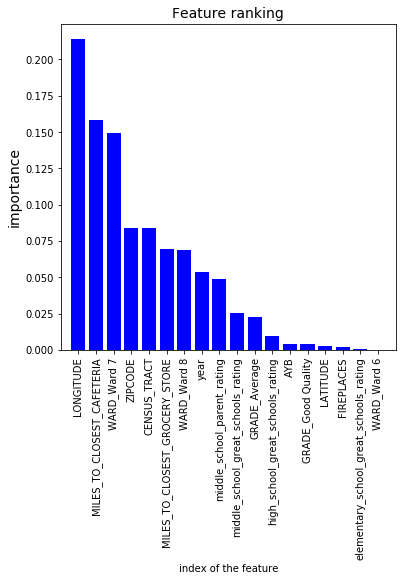

In [53]:
feature_names = X_train.columns

f, ax = plt.subplots(figsize=(6, 6))
plt.title("Feature ranking", fontsize = 14)
plt.bar(range(X_train.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("importance", fontsize = 14)
plt.xlabel("index of the feature", fontsize = 10)

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 25)
# Train the model on training data
pred = rf.fit(X_train, y_train).predict(X_test)

RMSE_1 = np.sqrt(mean_squared_error(y_test, pred))

print("The Root Mean Squared Error of Random Forest Regression is ",RMSE_1)

print("The R2 value of Random Forest Regression is ",r2_score(y_test,pred))

The Root Mean Squared Error of Random Forest Regression is  0.199958437935
The R2 value of Random Forest Regression is  0.624662252753


In [55]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

# Make predictions using the testing set
regr_pred = regr.predict(X_test)


print("MAE:", mean_absolute_error(y_test, regr_pred))
print("MSE:", mean_squared_error(y_test, regr_pred))

### print coefficients of linear regression

pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)

MAE: 0.191289789712
MSE: 0.0560962312299


,0,0
0,LONGITUDE,-2.660513
1,MILES_TO_CLOSEST_CAFETERIA,-0.023442
2,WARD_Ward 7,-0.196680
3,ZIPCODE,-0.000555
4,CENSUS_TRACT,-0.000008
5,MILES_TO_CLOSEST_GROCERY_STORE,0.021133
6,WARD_Ward 8,-0.446635
7,year,0.031520
8,middle_school_parent_rating,-0.013243
9,middle_school_great_schools_rating,0.002016


In [56]:
rmse_val = [] #to store rmse values for different k
mae_val=[]
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    error2 = sqrt(mean_absolute_error(y_test,pred)) #calculate rmse
    mae_val.append(error2) #store rmse values
    print('MAE value for k= ' , K , 'is:', error2)
    print('MSE value for k= ' , K , 'is:', error)
    print('-----------------------------')

MAE value for k=  1 is: 0.4487446034483623
MSE value for k=  1 is: 0.27090128056595897
-----------------------------
MAE value for k=  2 is: 0.42448547715641066
MSE value for k=  2 is: 0.238814828064888
-----------------------------
MAE value for k=  3 is: 0.41803788830463906
MSE value for k=  3 is: 0.22838144852447942
-----------------------------
MAE value for k=  4 is: 0.41461449889302193
MSE value for k=  4 is: 0.22337407638976772
-----------------------------
MAE value for k=  5 is: 0.41247238456945334
MSE value for k=  5 is: 0.22049013784255508
-----------------------------
MAE value for k=  6 is: 0.41230034656590336
MSE value for k=  6 is: 0.21942181294631996
-----------------------------
MAE value for k=  7 is: 0.41234091513046045
MSE value for k=  7 is: 0.21847209452848423
-----------------------------
MAE value for k=  8 is: 0.4117915650813441
MSE value for k=  8 is: 0.21792395071368886
-----------------------------
MAE value for k=  9 is: 0.41242269422725897
MSE value for k=

In [57]:
#Feature Scaling

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_train)

x_test=sc_X.fit_transform(X_test)


# most important SVR parameter is Kernel type. need to test out later.
regressor = SVR(kernel='rbf')
regressor.fit(X,y_train)
#5 Predicting a new result
y_pred = regressor.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

MAE: 0.285018597662
MSE: 0.109044745745


In [ ]:
#X_train, X_test, y_train, y_test = model_selection.train_test_split(df[features2], df['PRICE'], train_size=0.75,test_size=0.25, random_state=101)

In [58]:
from sklearn.preprocessing import LabelEncoder
cols = X_train.select_dtypes(include=['object']).columns
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train_dataset[c].values)) 
    X_train[c] = lbl.transform(list(X_train[c].values))

X_train.head()

import statsmodels.api as sm

from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error

X_train = sm.add_constant(X_train)

Pricing_model = sm.OLS(y_train,X_train)

result = Pricing_model.fit()

print(result.summary())

print("RMSE: ",np.sqrt(mean_squared_error(result.fittedvalues,y_train)))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     1043.
Date:                Wed, 27 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:46:20   Log-Likelihood:                 473.84
No. Observations:               21444   AIC:                            -909.7
Df Residuals:                   21425   BIC:                            -758.2
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------